# **Importing Libraries**

In [209]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Importing Dataset**

In [210]:
#panggil dataset yang telah disimpan di Google Drive pribadi
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
#explore the dataset
df = pd.read_excel('/content/drive/MyDrive/Pribadi/data_feedbacks.xlsx')
df

,label,ulasan
0,1,"Secara keseluruhan saya menyukai aplikasi ini,..."
1,1,sebenarnya adalah aplikasi yang sangat bagus...
2,1,Jujur luar biasa. Saya menganggap ini platform...
3,1,Saya beri 4 bintang karena versi PC memiliki f...
4,0,1. Autoscroll ke bawah tidak dapat dinonaktifk...
...,...,...
195,1,Terima kasih telah memperhatikan pengguna Inte...
196,0,Performa yang sangat tidak dapat diandalkan un...
197,0,Dibandingkan dengan : hanya 2 bintang! Sangat...
198,0,"Setelah update terbaru, terus berpindah fold..."


1    103
0     97
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


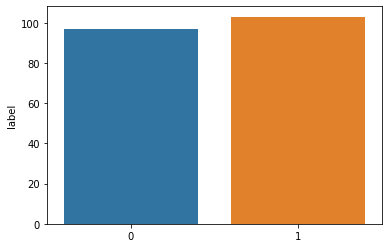

In [212]:
x=df['label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [213]:
df.isna().sum()

label     0
ulasan    0
dtype: int64

In [214]:
df['word_count'] = df['ulasan'].apply(lambda x: len(str(x).split()))
print(df[df['label']==1]['word_count'].mean()) #Positive feedbacks
print(df[df['label']==0]['word_count'].mean()) #Negative feedbacks

51.96116504854369
50.02061855670103


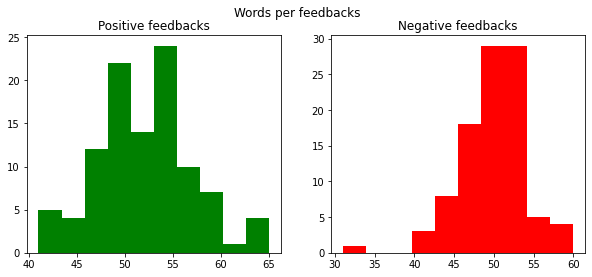

In [215]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Positive feedbacks')
train_words=df[df['label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Negative feedbacks')
fig.suptitle('Words per feedbacks')
plt.show()

In [216]:
# CHARACTER-COUNT
df['char_count'] = df['ulasan'].apply(lambda x: len(str(x)))
print(df[df['label']==1]['char_count'].mean()) #Positive feedbacks
print(df[df['label']==0]['char_count'].mean()) #Negative feedbacks

355.9611650485437
351.54639175257734


# **Data Cleaning**

## **Preprocessing**

In [217]:
#convert to lowercase, strip and remove punctuations
def preprocess(ulasan):
    ulasan = ulasan.lower() 
    ulasan = ulasan.strip()  
    ulasan = re.compile('<.*?>').sub('', ulasan) 
    ulasan = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', ulasan)  
    ulasan = re.sub('\s+', ' ', ulasan)  
    ulasan = re.sub(r'\[[0-9]*\]',' ',ulasan) 
    ulasan = re.sub(r'[^\w\s]', '', str(ulasan).lower().strip())
    ulasan = re.sub(r'\d',' ',ulasan) 
    ulasan = re.sub(r'\s+',' ',ulasan) 
    return ulasan

In [218]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [219]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

# **Final Preprocessing**

In [220]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [221]:
df['clean_text'] = df['ulasan'].apply(lambda x: finalpreprocess(x))
df.head()

,label,ulasan,word_count,char_count,clean_text
0,1,"Secara keseluruhan saya menyukai aplikasi ini,...",53,385,secara keseluruhan saya menyukai aplikasi ini ...
1,1,sebenarnya adalah aplikasi yang sangat bagus...,58,403,sebenarnya adalah aplikasi yang sangat bagus d...
2,1,Jujur luar biasa. Saya menganggap ini platform...,48,346,jujur luar biasa saya menganggap ini platform ...
3,1,Saya beri 4 bintang karena versi PC memiliki f...,50,319,saya beri bintang karena versi pc memiliki fit...
4,0,1. Autoscroll ke bawah tidak dapat dinonaktifk...,48,325,autoscroll ke bawah tidak dapat dinonaktifkan ...


In [222]:
X=df['ulasan'].values

In [223]:
Y=df['label'].values

In [224]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)

# **Count Vectorizer**

In [225]:
vec = CountVectorizer()

In [226]:
vec.fit(X_train)

CountVectorizer()

In [227]:
x_train=vec.transform(X_train)

In [228]:
x_test=vec.transform(X_test)

In [229]:
x_train

<160x1306 sparse matrix of type '<class 'numpy.int64'>'
	with 6429 stored elements in Compressed Sparse Row format>

In [230]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [231]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 16)                20912     
                                                                 
 dense_37 (Dense)            (None, 16)                272       
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 21,201
Trainable params: 21,201
Non-trainable params: 0
_________________________________________________________________


In [232]:
history = model.fit(x_train, Y_train,epochs=100,verbose=True,batch_size=16)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_12/dense_36/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_12/dense_36/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_12/dense_36/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


10/10 [==============================] - 1s 3ms/step - loss: 0.6959 - accuracy: 0.4812
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.5813
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6938
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.7875
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.8375
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5126 - accuracy: 0.8813
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.9438
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4077 - accuracy: 0.9688
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3442 - accuracy: 0.9875
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 0.2739 - accuracy: 0.9937
Epoch 11/100
10/10 [=

In [233]:
model.evaluate(x_train,Y_train)

5/5 [==============================] - 0s 3ms/step - loss: 2.2613e-04 - accuracy: 1.0000


[0.00022612600878346711, 1.0]

In [234]:
model.evaluate(x_test,Y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.0110 - accuracy: 0.6500


[1.0110445022583008, 0.6499999761581421]

In [235]:
#Done

# **TF-IDF Vectorizer**

In [236]:
vec = TfidfVectorizer()

In [237]:
vec.fit(X_train)

TfidfVectorizer()

In [238]:
x_train=vec.transform(X_train)
x_test=vec.transform(X_test)

In [239]:
x_train

<160x1306 sparse matrix of type '<class 'numpy.float64'>'
	with 6429 stored elements in Compressed Sparse Row format>

In [240]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, Y_train)

LogisticRegression()

In [241]:
score_test = lr.score(x_test, Y_test)

In [242]:
score_test

0.75

In [243]:
score_train = lr.score(x_train, Y_train)

In [244]:
score_train

0.96875

In [245]:
#Done

# **Building Model**

# **Running ML Algorithms**